# using OpenCv for stitching

In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 102kB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
##note example came from 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!unzip sample_of_images.zip

Archive:  sample_of_images.zip
   creating: sample_of_images/
  inflating: sample_of_images/frame08000.png  
  inflating: sample_of_images/frame08001.png  
  inflating: sample_of_images/frame08002.png  
  inflating: sample_of_images/frame08003.png  
  inflating: sample_of_images/frame08004.png  
  inflating: sample_of_images/frame08005.png  
  inflating: sample_of_images/frame08006.png  
  inflating: sample_of_images/frame08007.png  
  inflating: sample_of_images/frame08008.png  
  inflating: sample_of_images/frame08009.png  
  inflating: sample_of_images/frame08010.png  
  inflating: sample_of_images/frame08011.png  
  inflating: sample_of_images/frame08012.png  
  inflating: sample_of_images/frame08013.png  
  inflating: sample_of_images/frame08014.png  
  inflating: sample_of_images/frame08015.png  
  inflating: sample_of_images/frame08016.png  
  inflating: sample_of_images/frame08017.png  
  inflating: sample_of_images/frame08018.png  
  inflating: sample_of_images/frame08019.png 

In [ ]:
# select the image id (valid values 1,2,3, or 4)
imageId = 1
feature_extractor = 'surf'
feature_matching = 'bf'

In [ ]:
def make_square_images(image):
  crop_img = image[100:400, 350:650]
  return crop_img

In [ ]:
# def make_square_images(image):
# img = cv2.imread("./sample_of_images/frame08015.png")
# crop_img = img[100:400, 350:650]

# crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(10,5))
# plt.imshow(crop_img, cmap="gray")

# plt.axis('off')
# plt.show()

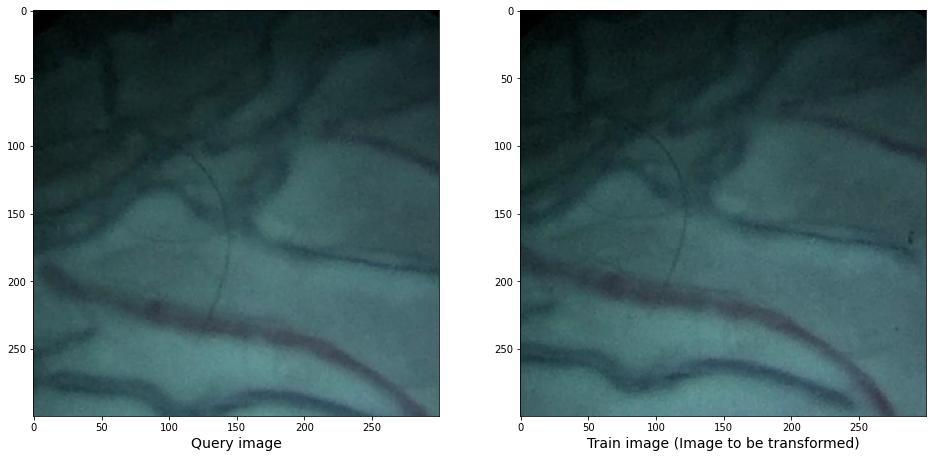

In [ ]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
trainImg = cv2.imread('./sample_of_images/frame08015.png')
trainImg = make_square_images(trainImg)
# trainImg = cv2.imread('S1.jpg')
trainImg = cv2.cvtColor(trainImg,cv2.COLOR_BGR2RGB)
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = cv2.imread('./sample_of_images/frame08020.png')
queryImg = make_square_images(queryImg)
# queryImg = cv2.imread('S2.jpg')
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg = cv2.cvtColor(queryImg,cv2.COLOR_BGR2RGB)
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

# plt.savefig("./output/input_img_"+str(imageId)+'.jpeg', bbox_inches='tight', dpi=300, optimize=True, format='jpeg')

plt.show()

In [ ]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [ ]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

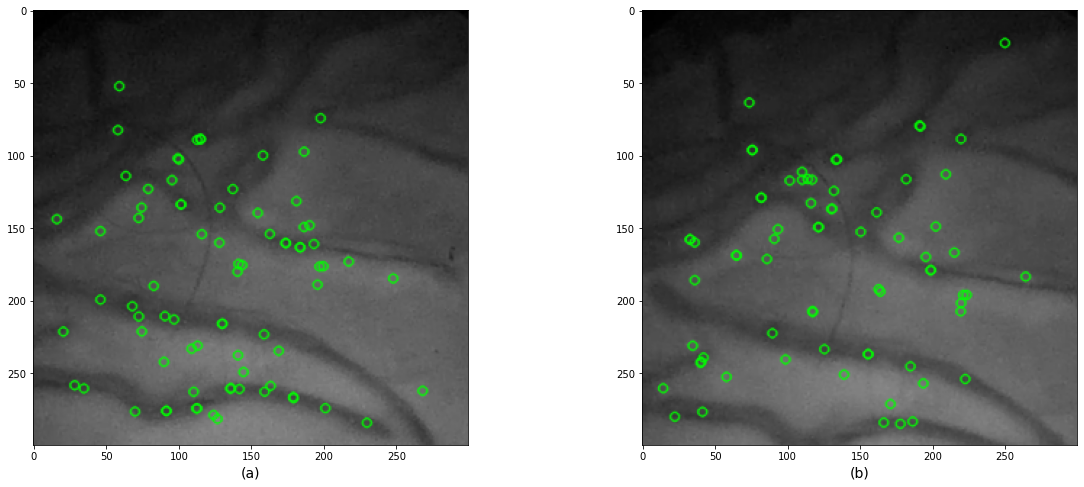

In [ ]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.savefig(feature_extractor + "_features_img_"+str(imageId)+'.jpeg', bbox_inches='tight', 
            dpi=300, optimize=True, format='jpeg')
plt.show()

In [ ]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [ ]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [ ]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 46


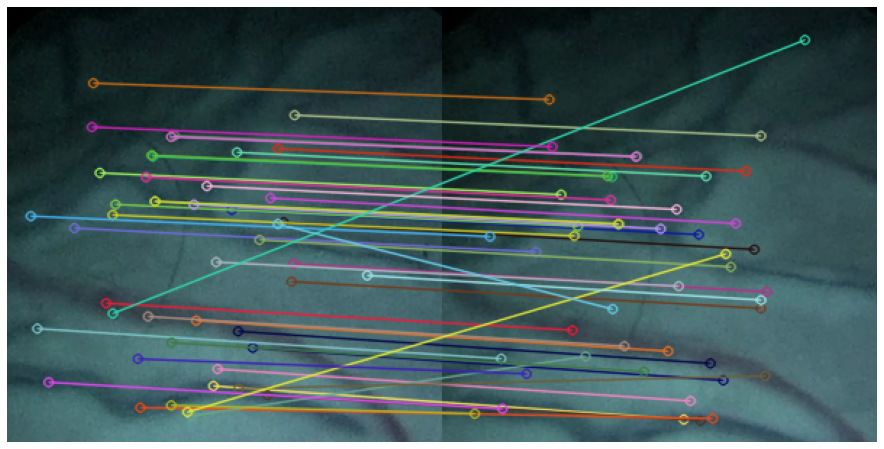

In [ ]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.axis('off')
plt.savefig(feature_matching + "_matching_img_"+str(imageId)+'.jpeg', bbox_inches='tight', 
            dpi=300, optimize=True, format='jpeg')
plt.show()

In [ ]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[1.06265150e+00 3.61349568e-02 1.05137283e+01]
 [2.84164766e-02 1.06647577e+00 5.90501860e+00]
 [7.57716108e-05 2.14892019e-05 1.00000000e+00]]


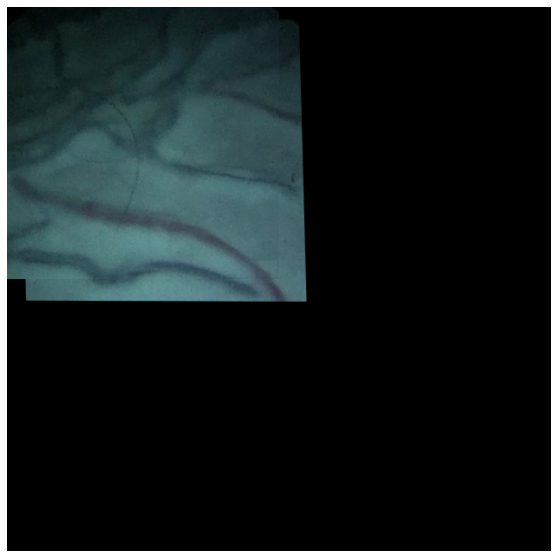

In [ ]:
# Apply panorama correction
# width = trainImg.shape[1] + queryImg.shape[1]
# height = trainImg.shape[0] + queryImg.shape[0]
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))

result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg


plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()


In [ ]:
trainImg.shape

(576, 1024, 3)

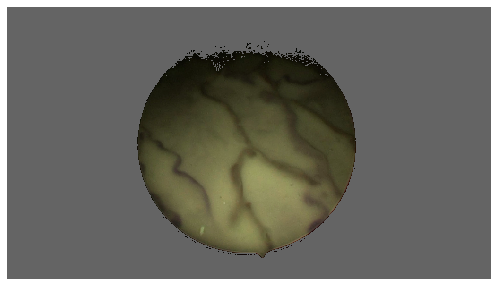

In [ ]:
new_img = np.zeros([queryImg.shape[0],queryImg.shape[1],3],dtype=np.uint8)
new_img.fill(100)

for ht in range(s_img.shape[0]): 
  for lt in range(s_img.shape[1]):  
    if np.all(s_img[ht, lt] > 2): 
      new_img[ht,lt] = s_img[ht, lt]
    


plt.figure(figsize=(10,5))
plt.imshow(new_img)

plt.axis('off')
plt.show()




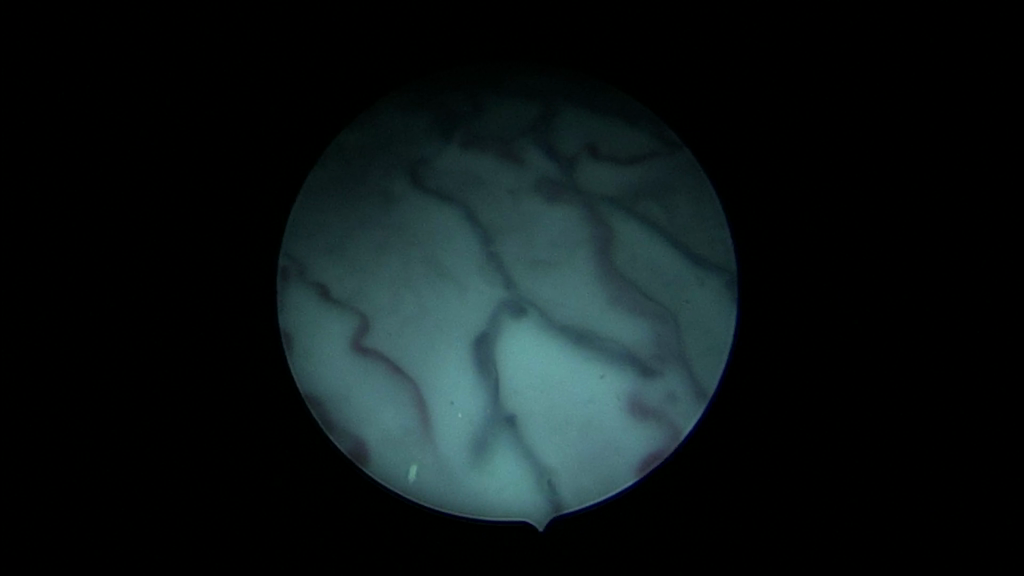

True

In [ ]:
import cv2
import numpy as np

file_name = "/path/to/img.png"

def cut(img):
  # crop image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  th, threshed = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY_INV)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  _, cnts, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = sorted(cnts, key=cv2.contourArea)[-1]
  x,y,w,h = cv2.boundingRect(cnt)
  new_img = img[y:y+h, x:x+w]

  return new_img        

def transBg(img):   
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  th, threshed = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY_INV)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  _, roi, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  mask = np.zeros(img.shape, img.dtype)

  cv2.fillPoly(mask, roi, (255,)*img.shape[2], )

  masked_image = cv2.bitwise_and(img, mask)

  return masked_image

def fourChannels(img):
  height, width, channels = img.shape
  if channels < 4:
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    return new_img

  return img

s_img = cv2.imread("sample_of_images/frame09064.png", -1)

# # set to 4 channels
s_img = fourChannels(s_img)

# remove white background
s_img = cut(s_img)

# set background transparent
s_img = transBg(s_img)


cv2_imshow(s_img)
cv2.imwrite("test.png", s_img)

In [ ]:
s_img.shape

(576, 1024, 4)